In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
X = np.loadtxt("...iris.txt")
labels = np.loadtxt("...iris_label.txt")

In [54]:
def Hbeta(D=np.array([]), beta=1.0):
    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [55]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):
        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


In [56]:
def tsne(X=np.array([]), no_dims=2, initial_dims=4, perplexity=30.0):
    # Initialize variables   
    (n, d) = X.shape
    max_iter = 500
    momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = np.maximum(P, 1e-6)
    print(P.shape)
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-6)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

    # Return solution
    return Y

In [50]:
Y = tsne(X, 2, 50, 20.0)

Computing pairwise distances...
Mean value of sigma: 1.000000
(150, 150)
Iteration 10: error is 0.234652
Iteration 20: error is 0.108161
Iteration 30: error is 0.076028
Iteration 40: error is 0.067344
Iteration 50: error is 0.065589
Iteration 60: error is 0.065239
Iteration 70: error is 0.065146
Iteration 80: error is 0.065148
Iteration 90: error is 0.065154
Iteration 100: error is 0.065163
Iteration 110: error is 0.065184
Iteration 120: error is 0.065213
Iteration 130: error is 0.065236
Iteration 140: error is 0.065250
Iteration 150: error is 0.065263
Iteration 160: error is 0.065275
Iteration 170: error is 0.065283
Iteration 180: error is 0.065290
Iteration 190: error is 0.065292
Iteration 200: error is 0.065294
Iteration 210: error is 0.065292
Iteration 220: error is 0.065291
Iteration 230: error is 0.065288
Iteration 240: error is 0.065284
Iteration 250: error is 0.065278
Iteration 260: error is 0.065272
Iteration 270: error is 0.065266
Iteration 280: error is 0.065259
Iteration 29

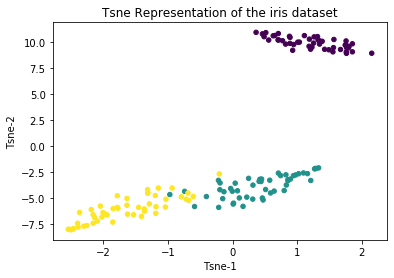

In [57]:
plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.title('Tsne Representation of the iris dataset')
plt.xlabel('Tsne-1')
plt.ylabel('Tsne-2')
plt.show()

In [58]:
def pca(X=np.array([]), no_dims=2):
    """Computing the Eigen Vectors which would serve as the new basis for the new dimensional data..."""
    (n, d) = X.shape
    # normalization of the data
    X = X - np.tile(np.mean(X, 0), (n, 1))
    # eigen vector computation
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    # new feature values along the first two eigen vectors.
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

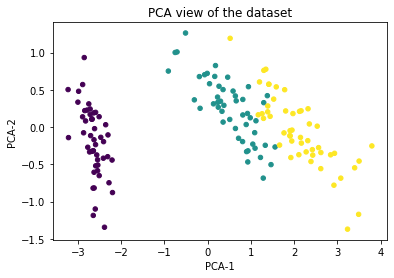

In [59]:
Y=pca(X,2)
plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.title('PCA view of the dataset')
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [39]:
pca = PCA(n_components=2)
points = pca.fit_transform(X)

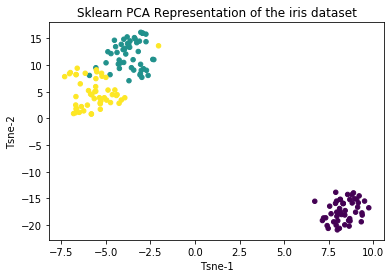

In [46]:
plt.scatter(points[:, 0], points[:, 1], 20, labels)
plt.title('Sklearn PCA Representation of the iris dataset')
plt.xlabel('Tsne-1')
plt.ylabel('Tsne-2')
plt.show()

In [43]:
tsne = TSNE(n_components=2, n_iter=500, random_state=29)
points = tsne.fit_transform(X)

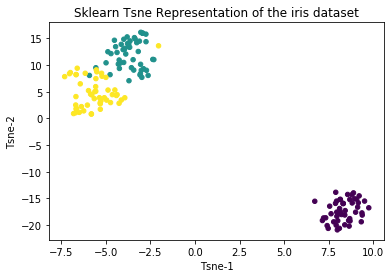

In [47]:
plt.scatter(points[:, 0], points[:, 1], 20, labels)
plt.title('Sklearn Tsne Representation of the iris dataset')
plt.xlabel('Tsne-1')
plt.ylabel('Tsne-2')
plt.show()